# Surrogate Modelling

This is a test script that models a basic pressure changer unit operation.

It uses idaes to generate some training data, then trains the model on the data to approximate the mathematical model.

After getting this to work well, we can try and get it to simulate a dynamic system.

In [25]:
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Compressor
from idaes.models.properties import iapws95
from idaes.core.util.model_statistics import degrees_of_freedom

m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = iapws95.Iapws95ParameterBlock()
m.fs.unit = Compressor(property_package=m.fs.properties)

m.fs.unit.inlet.flow_mol[0].fix(100)
m.fs.unit.inlet.enth_mol[0].fix(4000)
m.fs.unit.inlet.pressure[0].fix(101325)
m.fs.unit.work_isentropic.fix(10000000)
m.fs.unit.efficiency_isentropic.fix(0.9)

print(f'degrees of freedom: {degrees_of_freedom(m)}')

# Solve the model with a bunch of different values for inlet pressure and temperature and flow

# https://github.com/IDAES/examples-pse/blob/main/src/Examples/SurrMod/PySMO/PySMO_basics.ipynb
from idaes.core.surrogate.pysmo.sampling import HammersleySampling

# define the bounds for the input variables [inlet pressure, inlet temperature, flow]
bounds_info = [[51325, 1,3000],[1013250, 1000,100000]]
init_data = HammersleySampling(data_input=bounds_info, number_of_samples=250, sampling_type="creation")

# run the model for each set of input variables
# store the outlet pressure, temperature in a dataframe
# store the input variables in the same dataframe

import pandas as pd

solver = pyo.SolverFactory('ipopt')

#df = pd.DataFrame(columns=['pressure', 'enthalpy', 'flow', 'outlet_pressure', 'outlet_enthalpy', 'outlet_flow'])
# use numpy arrays instead
import numpy as np
datapoints = []


print("solving")
for [pressure, enth, flow] in init_data.sample_points():
    m.fs.unit.inlet.pressure[0].fix(pressure)
    m.fs.unit.inlet.enth_mol[0].fix(enth)
    m.fs.unit.inlet.flow_mol[0].fix(flow)
    solver.solve(m, tee=False)
    print(f'pressure: {pressure}, enthalpy: {enth}, flow: {flow}, outlet pressure: {pyo.value(m.fs.unit.outlet.pressure[0])}, outlet temperature: {pyo.value(m.fs.unit.outlet.enth_mol[0])}, outlet flow: {pyo.value(m.fs.unit.outlet.flow_mol[0])}')
    datapoints.append([pressure, enth, flow, pyo.value(m.fs.unit.outlet.pressure[0]), pyo.value(m.fs.unit.outlet.enth_mol[0])])
    


degrees of freedom: 0
Sampling type:  creation 

solving
pressure: 51325.0, enthalpy: 1.0, flow: 3000.0, outlet pressure: 192798479.32722747, outlet temperature: 3704.7037037037035, outlet flow: 3000.0
pressure: 55172.7, enthalpy: 500.5, flow: 35333.33333333333, outlet pressure: 15823053.329507692, outlet temperature: 814.9654088050315, outlet flow: 35333.33333333333
pressure: 59020.4, enthalpy: 250.75, flow: 67666.66666666666, outlet pressure: 8278478.371141519, outlet temperature: 414.95361247947454, outlet flow: 67666.66666666666
pressure: 62868.1, enthalpy: 750.25, flow: 13777.777777777777, outlet pressure: 40717231.65272682, outlet temperature: 1556.7016129032259, outlet flow: 13777.777777777777
pressure: 66715.8, enthalpy: 125.875, flow: 46111.11111111111, outlet pressure: 12139812.933540115, outlet temperature: 366.83885542168673, outlet flow: 46111.11111111111
pressure: 70563.5, enthalpy: 625.375, flow: 78444.44444444444, outlet pressure: 7157467.584650487, outlet temperature: 

/tmp/ipykernel_152049/395887311.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


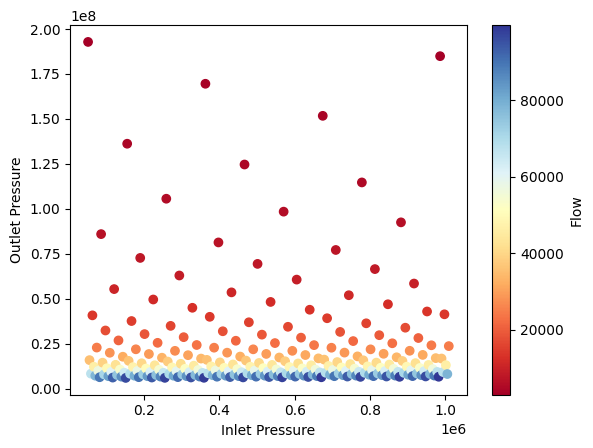

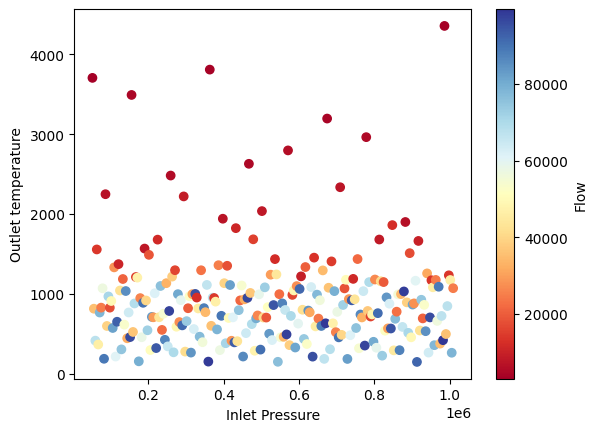

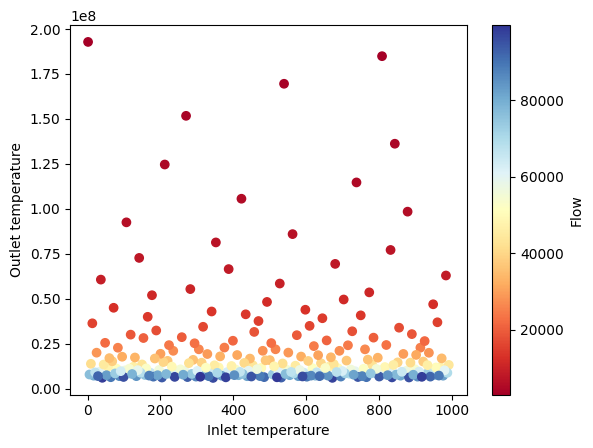

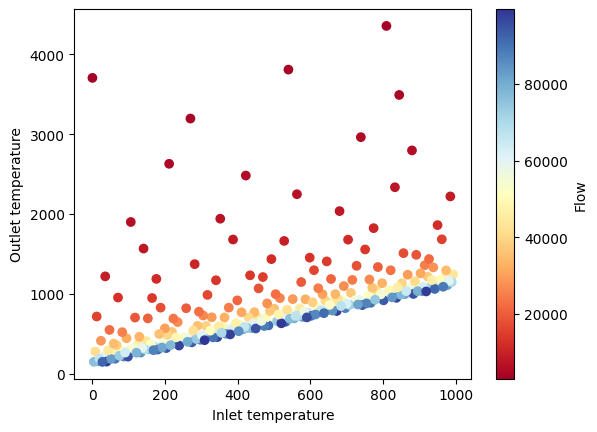

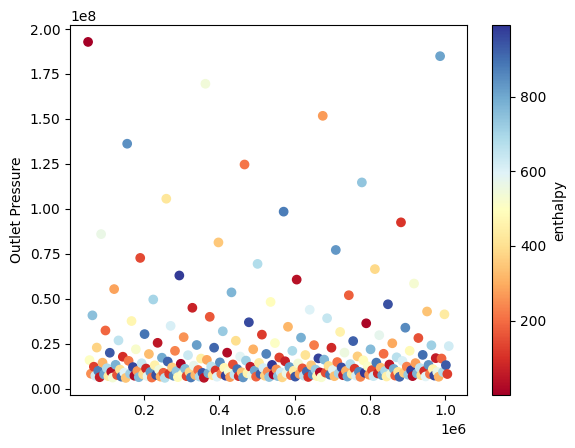

In [26]:
# plot the results

import matplotlib.pyplot as plt
import seaborn as sns

# scatter plot of the input pressure and temperature vs outlet pressure and temperature
df = pd.DataFrame(datapoints, columns=['pressure', 'enthalpy', 'flow', 'outlet_pressure', 'outlet_enthalpy'])
cm = plt.cm.get_cmap('RdYlBu')
scatter = plt.scatter(df['pressure'], df['outlet_pressure'], c=df['flow'], cmap=cm)
plt.xlabel('Inlet Pressure')
plt.ylabel('Outlet Pressure')
plt.colorbar(scatter, label='Flow')
plt.show()


scatter = plt.scatter(df['pressure'], df['outlet_enthalpy'], c=df['flow'], cmap=cm)
plt.xlabel('Inlet Pressure')
plt.ylabel('Outlet temperature')
plt.colorbar(scatter, label='Flow')
plt.show()

scatter = plt.scatter(df['enthalpy'], df['outlet_pressure'], c=df['flow'], cmap=cm)
plt.xlabel('Inlet temperature')
plt.ylabel('Outlet temperature')
plt.colorbar(scatter, label='Flow')
plt.show()

scatter = plt.scatter(df['enthalpy'], df['outlet_enthalpy'], c=df['flow'], cmap=cm)
plt.xlabel('Inlet temperature')
plt.ylabel('Outlet temperature')
plt.colorbar(scatter, label='Flow')
plt.show()

scatter = plt.scatter(df['pressure'], df['outlet_pressure'], c=df['enthalpy'], cmap=cm)
plt.xlabel('Inlet Pressure')
plt.ylabel('Outlet Pressure')
plt.colorbar(scatter, label='enthalpy')
plt.show()



Looks like there's some polynomial relationships there, maybe polynomialRegression can learn them.

In [ ]:
# Gonna try polynomial regression from pysmo, following https://github.com/IDAES/examples-pse/blob/main/src/Examples/SurrMod/PySMO/PySMO_basics.ipynb



from idaes.core.surrogate.pysmo.polynomial_regression import PolynomialRegression

poly_class = PolynomialRegression(original_data_input=brainin_data, regression_data_input=brainin_data, 
                                  maximum_polynomial_order=4, multinomials=1, training_split=0.8, number_of_crossvalidations=10, overwrite=True)

